# Time series Forecasting

## Importing libraries for time series forecasting

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-whitegrid')

from matplotlib.pyplot import figure

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from fbprophet import Prophet

from math import sqrt

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from matplotlib.pyplot import figure

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

## Data import, summary and preprocessing


In [ ]:
df = pd.read_csv('BPC_by_Trip_featuresbusy2.csv')

#dfAMx = df.groupby('Route').get_group('Bus Route A')   #Choose your Route
dfAMx = df.groupby('Route').get_group('Bus Route B')
#dfAMx = df.groupby('Route').get_group('Bus Route C')
dfAMx

In [4]:
dfAMx['Open Timestamp']=pd.to_datetime(pd.Series(dfAMx['Open Timestamp']), format="%m/%d/%Y  %H:%M")
dfAMx = dfAMx.drop(dfAMx[dfAMx['BusPassengerCount']<0].index)

In [5]:
dfAMx = dfAMx.resample('H', on='Open Timestamp').max()     #Choose Freq eg. 'H', '2H'

In [ ]:
dfAMx.isnull().sum() #check for null values

In [7]:
dfAMx=dfAMx.fillna(0)

In [8]:
y = dfAMx

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [ ]:
dfAMx.columns #check column headers

In [11]:
#dayofweek one hot encoding
x=y[['BusPassengerCount','WEEKEND','Public_Holidays','School_Holidays', 'Popularity_factor', 'Rain','Promo1',
     'Promo 2', 'Promo3', 'Attractions', 'Hotels', ' F&B (P)', 'F&B(A)', 'Monorail', 'Busy']] #Choose your exo
y['dayofweek'] = y.index.weekday
week_dummies = pd.get_dummies(y['dayofweek'])
week_dummies.columns = ['dayofweek-'+ str(w) for w in range(0,7)]
#y['TEMP_TIME'] = y.index.hour-2
#TEMP_TIME_dummies = pd.get_dummies(y['TEMP_TIME'])
#TEMP_TIME_dummies.columns = ['TEMP_TIME-'+ str(w) for w in range(0,12)]

TIME_OF_DAY_dummies = pd.get_dummies(y['TIME_OF_DAY'])
TIME_OF_DAY_dummies.columns = ['TIME_OF_DAY-'+ str(w) for w in range(0,5)]      
#Satday,Sunday
#z = pd.concat([x, week_dummies,TEMP_TIME_dummies], axis=1)
z = pd.concat([x, week_dummies, TIME_OF_DAY_dummies], axis=1)
z.head(1)

#z=y[['BusPassengerCount','dayofweek','Rain','TEMP_TIME','TIME_OF_DAY']]
#z

,BusPassengerCount,WEEKEND,Public_Holidays,School_Holidays,Popularity_factor,Rain,Promo1,Promo 2,Promo3,Attractions,Hotels,F&B (P),F&B(A),Monorail,Busy,dayofweek-0,dayofweek-1,dayofweek-2,dayofweek-3,dayofweek-4,dayofweek-5,dayofweek-6,TIME_OF_DAY-0,TIME_OF_DAY-1,TIME_OF_DAY-2,TIME_OF_DAY-3,TIME_OF_DAY-4
Open Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,4.0,0.0,1.0,0.0,7.576501,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0,0,0,1,0,0,0,0,0,0,1


In [12]:
# Create test & train data

tr_start,tr_end = '2021-01-01','2021-03-17'                      #Choose dates
te_start,te_end = '2021-03-18','2021-03-31'                      #Choose dates
train = z['BusPassengerCount'][tr_start:tr_end]#.dropna()
test = z['BusPassengerCount'][te_start:te_end]#.dropna()
exog_train = z.drop(['BusPassengerCount'],axis = 1)[tr_start:tr_end]#.dropna()
exog_test = z.drop(['BusPassengerCount'],axis = 1)[te_start:te_end]#.dropna()

In [13]:
## run ARIMAX model with exog data

arimax = sm.tsa.statespace.SARIMAX(train,seasonal_order=(0,0,0,0),exog = exog_train,freq='H',    #Choose 'H' or '2H'
                                  enforce_stationarity=False, enforce_invertibility=False,).fit()
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      BusPassengerCount   No. Observations:                 1824
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -5763.773
Date:                Sun, 26 Sep 2021   AIC                          11583.547
Time:                        21:03:13   BIC                          11737.778
Sample:                    01-01-2021   HQIC                         11640.443
                         - 03-17-2021                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
WEEKEND               0.4178      5.837      0.072      0.943     -11.023      11.859
Public_Holidays       2.7616      1.040      2.656      0.008       0.724       4.800
School_Holidays       4.1887      0.872      4.805      0.000       2.480       5.897
Popularity_factor     7.2988     74.341      0.098      0.922    -138.408     153.005
Rain                 -0.3239      0.556     -0.583      0.560      -1.414       0.766
Promo1                0.7668      0.185      4.140      0.000       0.404       1.130
Promo 2               0.7668      0.185      4.140      0.000       0.404       1.130
Promo3                0.7668      0.185      4.140      0.000       0.404       1.130
Attractions         -10.4448    122.789     -0.085      0.932    -251.107     230.217
Hotels               -1.5042     26.157     -0.058      0.954     -52.772      49.763
 F&B (P)            -10.4448    122.789     -0.085      0.932    -251.107     230.217
F&B(A)              -10.4448    122.789     -0.085      0.932    -251.107     230.217
Monorail            -10.4448    122.789     -0.085      0.932    -251.107     230.217
Busy                  2.7432      0.254     10.803      0.000       2.245       3.241
dayofweek-0          -1.7370     15.453     -0.112      0.911     -32.025      28.551
dayofweek-1          -0.5193     15.450     -0.034      0.973     -30.801      29.762
dayofweek-2          -1.3521     15.451     -0.088      0.930     -31.635      28.930
dayofweek-3          -0.6969     15.451     -0.045      0.964     -30.981      29.587
dayofweek-4          -2.3361     15.451     -0.151      0.880     -32.620      27.948
dayofweek-5          -0.4475     15.921     -0.028      0.978     -31.652      30.757
dayofweek-6          -1.9065     15.931     -0.120      0.905     -33.130      29.317
TIME_OF_DAY-0         1.4493     15.576      0.093      0.926     -29.078      31.977
TIME_OF_DAY-1         2.3536     30.698      0.077      0.939     -57.814      62.521
TIME_OF_DAY-2        -2.2075     30.700     -0.072      0.943     -62.379      57.964
TIME_OF_DAY-3        -1.7926     30.697     -0.058      0.953     -61.957      58.372
TIME_OF_DAY-4        -8.7984     30.716     -0.286      0.775     -69.001      51.404
ar.L1                 0.3270      0.015     22.520      0.000       0.299       0.355
sigma2               32.6461      0.662     49.321      0.000      31.349      33.943
===================================================================================
Ljung-Box (Q):                      311.85   Jarque-Bera (JB):              4791.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             1.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of 

In [15]:
## get evaluation metrics
pred_arimax = arimax.predict('2021-03-18 00:00:00','2021-03-31 23:00:00',exog = exog_test)[0:]     #Same dates as above. Check time if error.
evaluate_forecast(test, pred_arimax)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,0.765944,3.755497,2.33521,28.456935,inf,5.334504


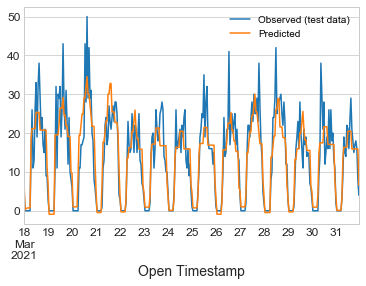

In [16]:
## plot test vs predicted values
pd.DataFrame({'Observed (test data)':test,'Predicted':pred_arimax}).plot();plt.show()

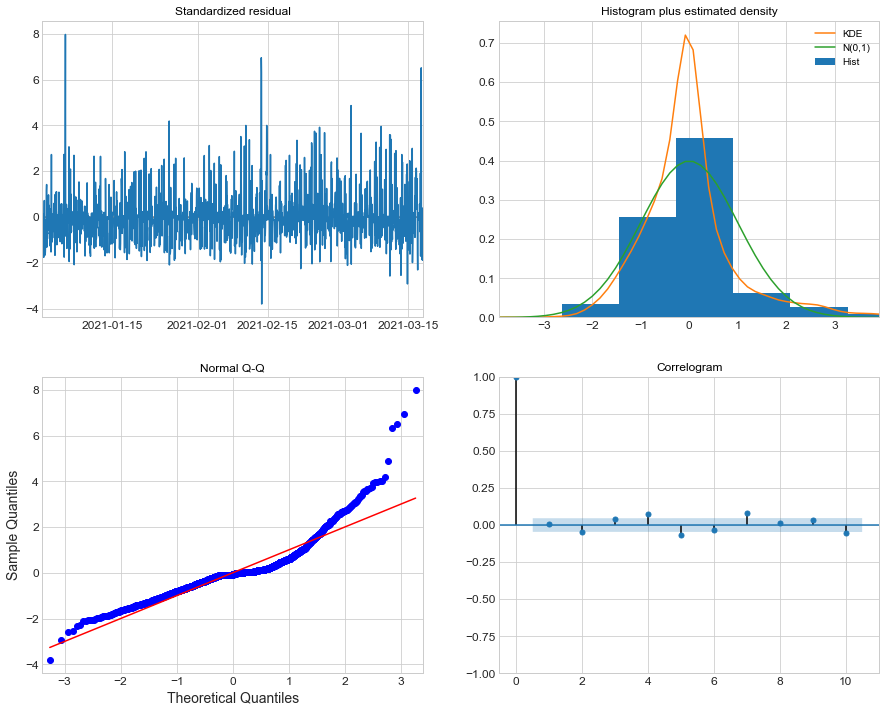

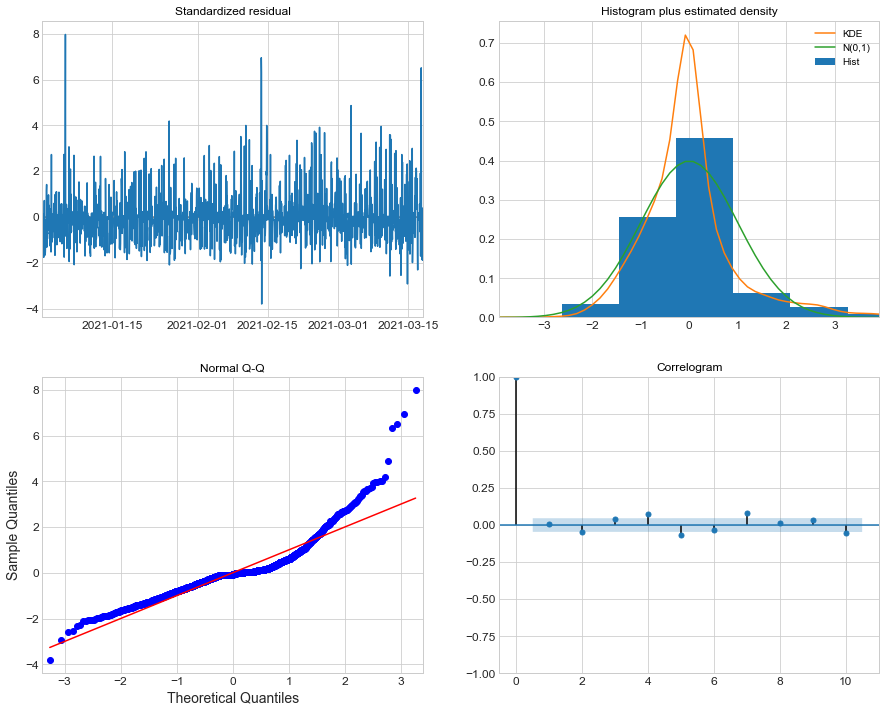

In [17]:
arimax.plot_diagnostics(figsize=(15, 12))

#### SARIMAX

In [18]:
## selecting model parameters - p & q for seasonal part

res = sm.tsa.seasonal_decompose(train.dropna(),freq=24)      #Freq = 12 if '2H', 24 if 'H'
resDiff = sm.tsa.arma_order_select_ic(res.seasonal, max_ar=3, max_ma=3, ic='aic', trend='c')
print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best.')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARMA(p,q) = (2, 3) is the best.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [19]:
## run SARIMAX model with seasonal order
sarimax = sm.tsa.statespace.SARIMAX(train,exog = exog_train,seasonal_order = (2, 1, 3, 24),    #take (x, y) from above and input (x, 1, y, Freq)
                                enforce_stationarity=False, enforce_invertibility=False,freq='H',validate_specification = False).fit()
sarimax.summary()                                                                            #'H' or '2H' same as earlier

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                          BusPassengerCount   No. Observations:                 1824
Model:             SARIMAX(1, 0, 0)x(2, 1, [1, 2, 3], 24)   Log Likelihood               -5302.120
Date:                                    Sun, 26 Sep 2021   AIC                          10670.240
Time:                                            22:16:32   BIC                          10850.227
Sample:                                        01-01-2021   HQIC                         10736.819
                                             - 03-17-2021                                         
Covariance Type:                                      opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
WEEKEND               1.3107      5.001      0.262      0.793      -8.491      11.112
Public_Holidays       2.9129      0.977      2.981      0.003       0.998       4.828
School_Holidays       3.3746      0.852      3.959      0.000       1.704       5.045
Popularity_factor    16.0125     14.632      1.094      0.274     -12.666      44.690
Rain                 -0.0319      0.540     -0.059      0.953      -1.090       1.026
Promo1                0.3618      4.327      0.084      0.933      -8.120       8.843
Promo 2               0.3618        nan        nan        nan         nan         nan
Promo3                0.3618        nan        nan        nan         nan         nan
Attractions         -19.2043   2.69e+04     -0.001      0.999   -5.28e+04    5.28e+04
Hotels               -4.4162     15.591     -0.283      0.777     -34.974      26.141
 F&B (P)            -19.2043   2.69e+04     -0.001      0.999   -5.28e+04    5.28e+04
F&B(A)              -19.2043   2.69e+04     -0.001      0.999   -5.28e+04    5.28e+04
Monorail            -19.2043   2.69e+04     -0.001      0.999   -5.28e+04    5.28e+04
Busy                  1.2922      0.261      4.946      0.000       0.780       1.804
dayofweek-0          -0.6708   2.06e+04  -3.26e-05      1.000   -4.04e+04    4.03e+04
dayofweek-1           0.6955   2.06e+04   3.38e-05      1.000   -4.03e+04    4.04e+04
dayofweek-2          -0.3889   2.06e+04  -1.89e-05      1.000   -4.04e+04    4.03e+04
dayofweek-3           0.4192   2.06e+04   2.04e-05      1.000   -4.03e+04    4.04e+04
dayofweek-4          -0.2674   2.06e+04   -1.3e-05      1.000   -4.04e+04    4.03e+04
dayofweek-5           1.0319   2.06e+04   5.01e-05      1.000   -4.03e+04    4.04e+04
dayofweek-6          -0.8196   2.06e+04  -3.98e-05      1.000   -4.04e+04    4.03e+04
TIME_OF_DAY-0        19.2043   1.28e+05      0.000      1.000    -2.5e+05     2.5e+05
TIME_OF_DAY-1       2.38e-06   3.08e+04   7.73e-11      1.000   -6.04e+04    6.04e+04
TIME_OF_DAY-2      -8.53e-07   8.46e+04  -1.01e-11      1.000   -1.66e+05    1.66e+05
TIME_OF_DAY-3      2.622e-06   1.88e+05    1.4e-11      1.000   -3.68e+05    3.68e+05
TIME_OF_DAY-4       -19.2043   1.13e+05     -0.000      1.000   -2.22e+05    2.22e+05
ar.L1                 0.3450      0.014     25.439      0.000       0.318       0.372
ar.S.L24             -0.9181      0.073    -12.498      0.000      -1.062      -0.774
ar.S.L48             -0.4372      0.077     -5.675      0.000      -0.588      -0.286
ma.S.L24              0.0809      0.071      1.132      0.258      -0.059       0.221
ma.S.L48             -0.4227      0.073     -5.781      0.000      -0.566      -0.279
ma.S.L72             -0.5217      0.068     -7.639      0.000      -0.656      -0.388
sigma2               26.6347      0.536     49.653 

In [21]:
## get evaluation metrics
pred_sarimax = sarimax.predict('2021-03-18 00:00:00','2021-03-31 23:00:00', exog = exog_test)[0:]    #Same dates as above. Check time if error.
evaluate_forecast(test, pred_sarimax)

,r2_score,mean_absolute_error,median_absolute_error,mse,mape,rmse
0,0.768814,3.591327,2.221769,28.107978,inf,5.301696


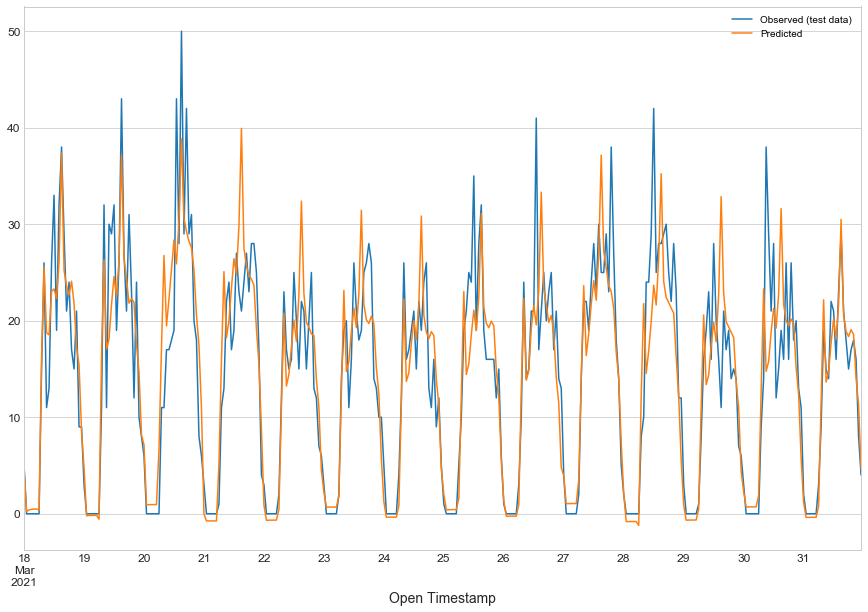

In [22]:
pd.DataFrame({'Observed (test data)':test,'Predicted':pred_sarimax}).plot(figsize=(15,10));#plt.show()
#plt.ylabel("Bus Passenger Count")
#plt.savefig('D:/007 - Data/Capstone Presentation/charts/Route_A_SARIMAX_2H.png', dpi=200, bbox_inches='tight')

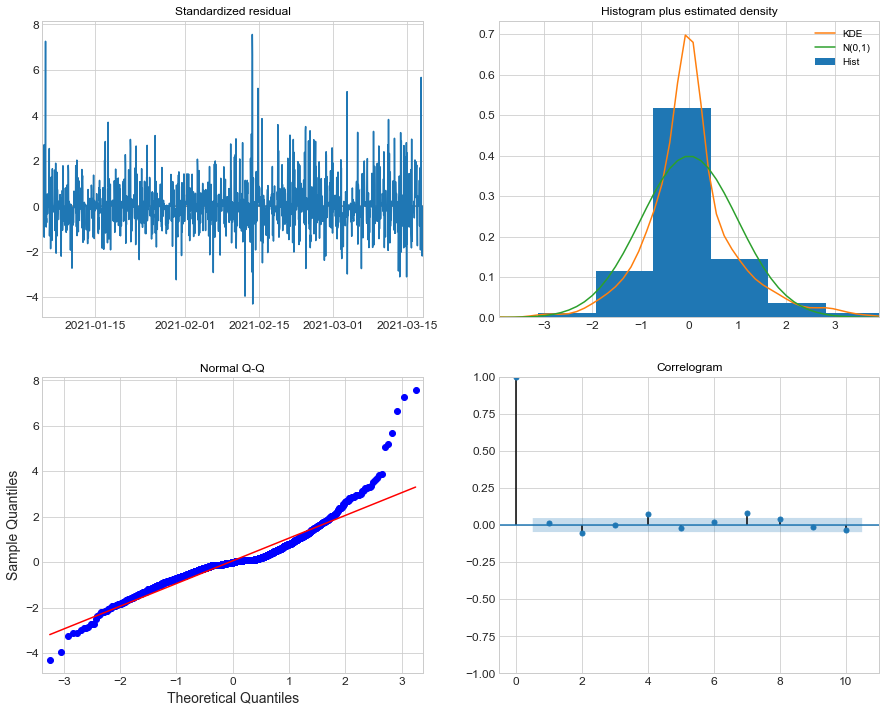

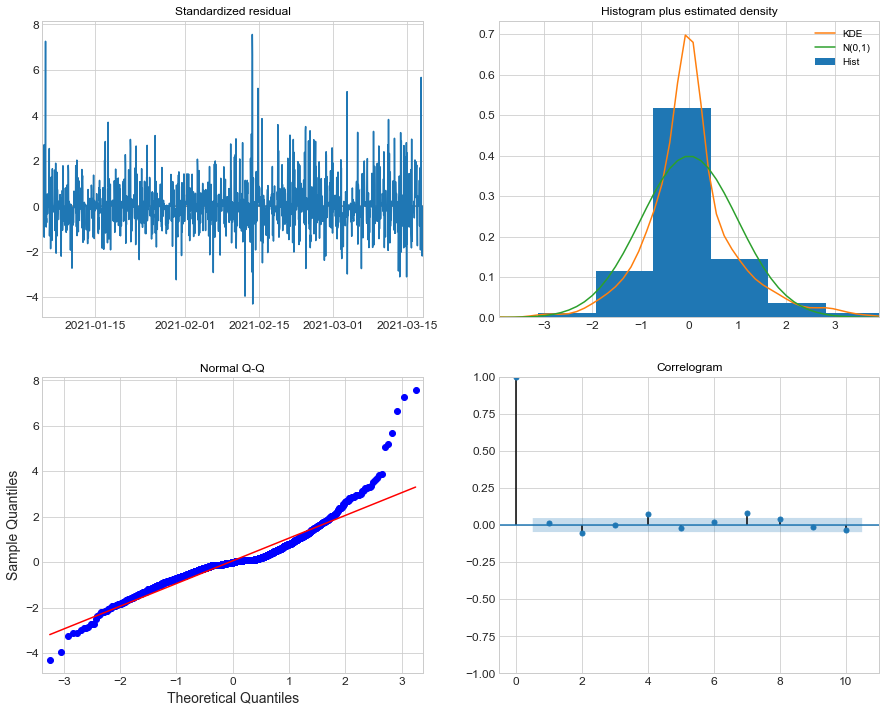

In [23]:
sarimax.plot_diagnostics(figsize=(15, 12))